In [1]:
import numpy
from matplotlib import pyplot
from scipy.constants import c
from numpy import pi as pi
from mpl_toolkits.axes_grid1 import make_axes_locatable

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

In [2]:
def beam_width(frequency, diameter= 4, epsilon = 1):
    
    sigma =  epsilon*c/(frequency*diameter)
    width = numpy.sin(0.5*sigma)
    return width

def beam_response(source_l, source_m, nu):
    sigma = beam_width(nu)
    beam_attenuation = numpy.exp(-(source_l**2. +  source_m**2.)/(2*sigma**2))
    return beam_attenuation

In [3]:
class PointSourceSky:
    
    def __init__(self):
        self.flux_0 = None
        self.frequency_0 = None
        self.l_coordinate = None
        self.m_coordinate = None
        self.spectral_index = 0.8
        
        
    def add_source(self, flux, frequency_0 = 150e6, l_coordinate = 0, m_coordinate =0 , spectral_index=0.8):
        assert isinstance(flux, numpy.ndarray), "Please input a numpy array for flux"
        assert isinstance(frequency_0, numpy.ndarray), "Please input a numpy array for frequency"
        assert isinstance(l_coordinate, numpy.ndarray), "Please input a numpy array l coordinate"
        assert isinstance(m_coordinate, numpy.ndarray), "Please input a numpy array m coordinate"
        assert isinstance(spectral_index, numpy.ndarray), "Please input a numpy array spectral index"

        if self.flux_0 == None:
            self.flux_0 = flux
            self.frequency_0 = frequency_0
            self.l_coordinate = l_coordinate
            self.m_coordinate = m_coordinate
            self.spectral_index = spectral_index
        else:
            self.flux_0.append(flux)
            self.frequency_0.append(frequency_0)
            self.l_coordinate.append(l_coordinate)
            self.m_coordinate.append(m_coordinate)
            self.spectral_index.append(spectral_index)
        
        return

## The Numerical Covariance Calculation

In [4]:
import os
import numpy
import powerbox
import time
from scipy import interpolate

from matplotlib import pyplot
from matplotlib.widgets import Slider
from scipy.constants import c as light_speed

import sys
sys.path.append('../../../redundant_calibration/code/SCAR')
from RadioTelescope import antenna_gain_creator
from RadioTelescope import baseline_converter
from RadioTelescope import xyz_position_creator
from SkyModel import flux_list_to_sky_image
from SkyModel import flux_distribution
from quick_simulation_visibility_covariance import lm_to_theta_phi
from quick_simulation_visibility_covariance import mwa_tile_beam
from quick_simulation_visibility_covariance import interactive_frequency_plotter

/Users/ronniyjoseph/anaconda2/envs/python3/lib/python3.6/site-packages/powerbox/dft.py:51: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


In [12]:
def visibility_beam_covariance(xyz_positions, frequency_range, sky_param, sky_seed = 0, broken_tiles = 1, 
                               load = True, verbose = True, return_model = False):
    baseline_index = 0
    gain_table = antenna_gain_creator(xyz_positions, frequency_range)
    baseline_table = baseline_converter(xyz_positions, gain_table, frequency_range, verbose = verbose)
    
    if sky_param[0] == 'random':
        all_flux, all_l, all_m = flux_distribution(['random', sky_seed])
    elif sky_param[0] == 'point':
        all_flux, all_l, all_m = flux_distribution(['single', sky_param[1],
                                                    sky_param[2], sky_param[3]])
    point_source_list = numpy.stack((all_flux, all_l, all_m), axis=1)
    
    if verbose:
        print("Creating the sky\n")
    sky_cube, l_coordinates, m_coordinates = flux_list_to_sky_image(point_source_list, baseline_table)
    ll, mm, ff = numpy.meshgrid(l_coordinates, m_coordinates, frequency_range)
    tt, pp, = lm_to_theta_phi(ll, mm)

    if not load:
        if verbose:
            print("Creating the idealised MWA beam\n")
        ideal_beam = mwa_tile_beam(tt, pp, frequency=ff)
        if not os.path.exists("beam_maps"):
            print("")
            print("Creating beam map folder locally!")
            os.makedirs("beam_maps")
        numpy.save(f"beam_maps/ideal_beam_map.npy", ideal_beam)
    if load:
        if verbose:
            print("Loading the idealised MWA beam\n")
        ideal_beam = numpy.load(f"beam_maps/ideal_beam_map.npy")

    baseline_selection = numpy.array([baseline_table[baseline_index]])
    if broken_tiles == 1:
        visibility_realisations, model_visibility =  single_broken_realisations(baseline_selection, sky_cube,
                                                                                ideal_beam,
                                                                                tt, pp, ff, frequency_range)
    elif broken_tiles == 2:
        visibility_realisations, model_visibility =  double_broken_realisations(baseline_selection, sky_cube,
                                                                                ideal_beam,
                                                                                tt, pp, ff, frequency_range)

    if verbose:
        print("Calculating the covariance matrix for a single baseline over the frequency range")

    visibility_covariance = numpy.cov(visibility_realisations)
    
    if return_model:
        data = (visibility_realisations, model_visibility)
    else:
        data = visibility_realisations
    
    return data

def double_broken_realisations(baseline_selection, sky_cube, ideal_beam, tt,pp,ff, frequency_range, verbose = False, load = False):
    if verbose:
        print("Iterating over 256 realisations of a perturbed MWA beam")
    visibility_realisations = numpy.zeros((frequency_range.shape[0], 16**2), dtype=complex)
    model_visibility = numpy.zeros((frequency_range.shape[0]), dtype = complex)
    combination_index = 0

    for faulty_dipole1 in range(16):
        beam1 = perturbed_beam(tt, pp,ff, faulty_dipole = faulty_dipole1, load = load)
        
        for faulty_dipole2 in range(16):
            beam2 = perturbed_beam(tt, pp,ff, faulty_dipole = faulty_dipole2, load = load)
            #print(f"Extracting Visibilities")
            
            
            for frequency_index in range(len(frequency_range)):
                visibility_realisations[frequency_index, combination_index] = visibility_extractor(
                    baseline_selection[:, :, frequency_index], sky_cube[:, :, frequency_index],
                    beam1[:, :, frequency_index], beam2[:, :, frequency_index])

                model_visibility[frequency_index] = visibility_extractor(
                    baseline_selection[:, :, frequency_index], sky_cube[:, :, frequency_index],
                    ideal_beam[:, :, frequency_index], ideal_beam[:, :, frequency_index])
                
            combination_index += 1
    return visibility_realisations, model_visibility

def single_broken_realisations(baseline_selection,sky_cube, ideal_beam, tt, pp, ff, frequency_range, verbose =  False, load = False):
    visibility_realisations = numpy.zeros((frequency_range.shape[0], 16), dtype=complex)
    model_visibility = numpy.zeros((frequency_range.shape[0]), dtype = complex)

    if verbose:
        print("Iterating over 16 realisations of a perturbed MWA beam")
    for faulty_dipole in range(16):
        dipole_weights = numpy.zeros(16) + 1
        dipole_weights[faulty_dipole] = 0
        if load:
            print(f"Loading perturbed tile beam for dipole {faulty_dipole}")
            perturbed_beam = numpy.load(f"beam_maps/perturbed_dipole_{faulty_dipole}_map.npy")
        elif not load:
            #print(f"Generating perturbed tile beam for dipole {faulty_dipole}")
            perturbed_beam = mwa_tile_beam(tt, pp, weights=dipole_weights, frequency=ff)
            if not os.path.exists("beam_maps"):
                print("")
                print("Creating beam map folder locally!")
                os.makedirs("beam_maps")
            numpy.save(f"beam_maps/perturbed_dipole_{faulty_dipole}_map.npy", perturbed_beam)

        #print(f"Extracting Visibilities")
        for frequency_index in range(len(frequency_range)):
            visibility_realisations[frequency_index, faulty_dipole] = visibility_extractor(
                baseline_selection[:, :, frequency_index], sky_cube[:, :, frequency_index],
                ideal_beam[:, :, frequency_index], perturbed_beam[:, :, frequency_index])
            
            model_visibility[frequency_index] = visibility_extractor(
                baseline_selection[:, :, frequency_index], sky_cube[:, :, frequency_index],
                ideal_beam[:, :, frequency_index], ideal_beam[:, :, frequency_index])
    
    return visibility_realisations, model_visibility
    
def perturbed_beam(tt, pp,ff, faulty_dipole = False, load = False):
    if load:
        print(f"Loading perturbed tile beam for dipole {faulty_dipole}")
        perturbed_beam = numpy.load(f"beam_maps/perturbed_dipole_{faulty_dipole}_map.npy")
    elif not load:
        dipole_weights = numpy.zeros(16) + 1
        dipole_weights[faulty_dipole] = 0
        perturbed_beam = mwa_tile_beam(tt, pp, weights=dipole_weights, frequency=ff)
        if not os.path.exists("beam_maps"):
            print("")
            print("Creating beam map folder locally!")
            os.makedirs("beam_maps")
            numpy.save(f"beam_maps/perturbed_dipole_{faulty_dipole}_map.npy", perturbed_beam)
    
    return perturbed_beam
    
    
def visibility_extractor(baseline_table, sky_cube, antenna1_response, antenna2_response):
    apparent_sky = sky_cube * antenna1_response * numpy.conj(antenna2_response)
    padding_factor = 3

    padded_sky = numpy.pad(apparent_sky, padding_factor * len(apparent_sky), mode="constant")
    shifted_image = numpy.fft.ifftshift(padded_sky, axes=(0, 1))
    visibility_grid, uv_coordinates = powerbox.dft.fft(shifted_image, L=2 * (2 * padding_factor + 1), axes=(0, 1))
    measured_visibilities = uv_list_to_baseline_measurements(baseline_table, visibility_grid, uv_coordinates)

    return measured_visibilities


def uv_list_to_baseline_measurements(baseline_table, visibility_grid, uv_grid):

    u_bin_centers = uv_grid[0]
    v_bin_centers = uv_grid[1]

    # now we have the bin edges we can start binning our baseline table
    # Create an empty array to store our baseline measurements in
    visibility_data = visibility_grid

    real_component = interpolate.RegularGridInterpolator((u_bin_centers, v_bin_centers), numpy.real(visibility_data))
    imag_component = interpolate.RegularGridInterpolator((u_bin_centers, v_bin_centers), numpy.imag(visibility_data))
    visibilities = real_component(baseline_table[:, 2:4]) + \
                   1j * imag_component(baseline_table[:, 2:4])
    return visibilities

## Multi Source

In [6]:
calculate_covariance = True

dx = 20
dy = 10

sky_param = ['random', 200, -0.10, 0.0]
frequency_range = numpy.linspace(140, 160, 10)*1e6

# create array
noise_param = [False, 20e3, 40e3, 120]
beam_param = ['gaussian', 0.25, 0.25]
# telescope_param = ["hex", 14., 0, 0]
telescope_param = ["linear", 10, 5, 0]




flux = numpy.array([sky_param[1]])
frequency_0 = numpy.array([150e6])
source_l = numpy.array([sky_param[2]])
source_m = numpy.array([sky_param[3]])
spectral_index = numpy.array([0.8])


sky_model = PointSourceSky()
sky_model.add_source(flux, frequency_0, source_l, source_m, spectral_index)


xyz_positions = numpy.zeros((2,4))
xyz_positions[0,1] = 0
xyz_positions[0,2] = 0

xyz_positions[1,1] = dx
xyz_positions[1,2] = dy

ff1, ff2 = numpy.meshgrid(frequency_range, frequency_range)
visibility_realisations1, model_1 = visibility_beam_covariance(xyz_positions, frequency_range, sky_param, broken_tiles = 1
                                                      ,load=True, return_model = True)
visibility_realisations2, model_2 = visibility_beam_covariance(xyz_positions, frequency_range, sky_param, broken_tiles = 2
                                                      ,load=True, return_model = True)



Converting xyz to uvw-coordinates

Number of antenna = 2
Total number of baselines = 1
Creating the sky

Loading the idealised MWA beam



/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:276: RuntimeWarning: invalid value encountered in arcsin
  theta = numpy.arcsin(numpy.sqrt(ll ** 2. + mm ** 2.))
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:277: RuntimeWarning: divide by zero encountered in true_divide
  phi = numpy.arctan(mm / ll)
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:277: RuntimeWarning: invalid value encountered in arctan
  phi = numpy.arctan(mm / ll)


Calculating the covariance matrix for a single baseline over the frequency range

Converting xyz to uvw-coordinates

Number of antenna = 2
Total number of baselines = 1
Creating the sky

Loading the idealised MWA beam



KeyboardInterrupt: 

(10, 10, 16)


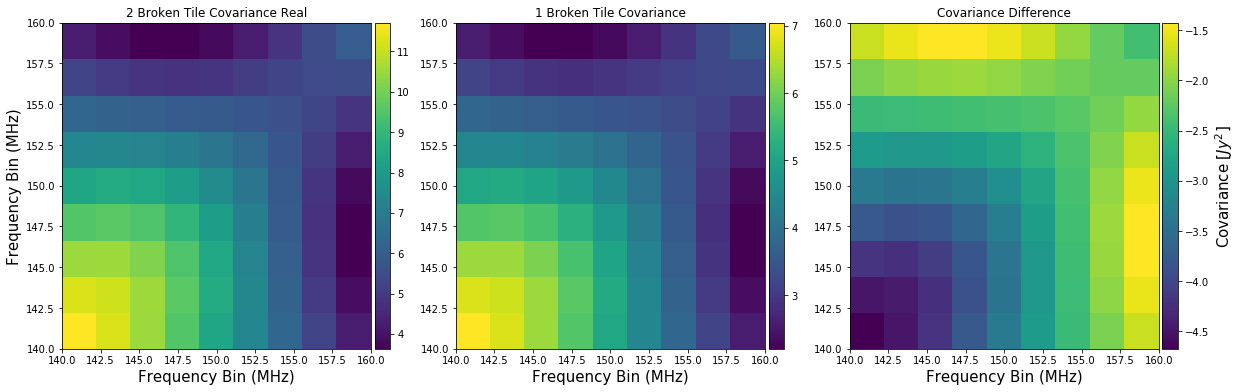

In [28]:
numerical_covariance1 = numpy.cov(visibility_realisations1)
numerical_covariance2 = numpy.cov(visibility_realisations2)

dV = visibility_realisations1 - numpy.tile(model_1.T,(16,1)).T
perturbation_covariance_npcov = numpy.cov(dV)

dV_tiled = numpy.tile(dV,(10,1,1))
dV_tiledT= numpy.transpose(dV_tiled, axes = (1,0,2))

print(dV_tiledT.shape)
perturbation_covariance_manual= numpy.mean(dV_tiled*numpy.conj(dV_tiledT), axis = 2) - \
    numpy.mean(dV_tiled, axis = 2 )*numpy.mean(numpy.conj(dV_tiledT), axis = 2 ) 

fontsize = 15
if calculate_covariance:
    %matplotlib inline
    figure = pyplot.figure(figsize = (20,6))
    
    covariance_plot_2tile = figure.add_subplot(131)
    covariance_plot_1tile = figure.add_subplot(132)
    covariance_plotdiff = figure.add_subplot(133)

    numerical_plot_2tile = covariance_plot_2tile.pcolor(frequency_range/1e6, frequency_range/1e6,
                                              numpy.real(numerical_covariance2))
    covariance_plot_2tile.set_xlabel('Frequency Bin (MHz)', fontsize = fontsize)
    covariance_plot_2tile.set_ylabel('Frequency Bin (MHz)', fontsize = fontsize)

    covariance_plot_2tile.set_title("2 Broken Tile Covariance Real" )
    n2_cax = colorbar(numerical_plot_2tile)

    
    numerical_plot_1tile = covariance_plot_1tile.pcolor(frequency_range/1e6, frequency_range/1e6,
                                              numpy.real(numerical_covariance1))
    covariance_plot_1tile.set_xlabel('Frequency Bin (MHz)', fontsize = fontsize)
    covariance_plot_1tile.set_title("1 Broken Tile Covariance" )
    n_cax = colorbar(numerical_plot_1tile)


    
    numerical_plotdiff = covariance_plotdiff.pcolor(frequency_range/1e6, frequency_range/1e6,
                                                    numpy.real(numerical_covariance1 - numerical_covariance2))
    covariance_plotdiff.set_xlabel('Frequency Bin (MHz)', fontsize = fontsize)
    covariance_plotdiff.set_title("Covariance Difference" )
    ndiff_cax = colorbar(numerical_plotdiff)
    ndiff_cax.set_label(r"Covariance $[Jy^2]$", fontsize = fontsize)
    
    pyplot.show()

## Single Source

In [14]:
calculate_covariance = True

dx = 20
dy = 10

sky_param = ['point', 200, -0.10, 0.0]
frequency_range = numpy.linspace(140, 160, 10)*1e6

# create array
noise_param = [False, 20e3, 40e3, 120]
beam_param = ['gaussian', 0.25, 0.25]
# telescope_param = ["hex", 14., 0, 0]
telescope_param = ["linear", 10, 5, 0]




flux = numpy.array([sky_param[1]])
frequency_0 = numpy.array([150e6])
source_l = numpy.array([sky_param[2]])
source_m = numpy.array([sky_param[3]])
spectral_index = numpy.array([0.8])


sky_model = PointSourceSky()
sky_model.add_source(flux, frequency_0, source_l, source_m, spectral_index)


xyz_positions = numpy.zeros((2,4))
xyz_positions[0,1] = 0
xyz_positions[0,2] = 0

xyz_positions[1,1] = dx
xyz_positions[1,2] = dy

ff1, ff2 = numpy.meshgrid(frequency_range, frequency_range)


In [15]:
visibility_realisations1, model_1 = visibility_beam_covariance(xyz_positions, frequency_range, sky_param, broken_tiles = 1
                                                      ,load=True, return_model = True)


Converting xyz to uvw-coordinates

Number of antenna = 2
Total number of baselines = 1
Creating the sky

Loading the idealised MWA beam



/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:279: RuntimeWarning: invalid value encountered in arcsin
  theta = numpy.arcsin(numpy.sqrt(ll ** 2. + mm ** 2.))
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:280: RuntimeWarning: divide by zero encountered in true_divide
  phi = numpy.arctan(mm / ll)
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:280: RuntimeWarning: invalid value encountered in arctan
  phi = numpy.arctan(mm / ll)


Calculating the covariance matrix for a single baseline over the frequency range


In [ ]:
visibility_realisations2, model_2 = visibility_beam_covariance(xyz_positions, frequency_range, sky_param, broken_tiles = 2
                                                      ,load=True, return_model = True)

(10, 10, 16)


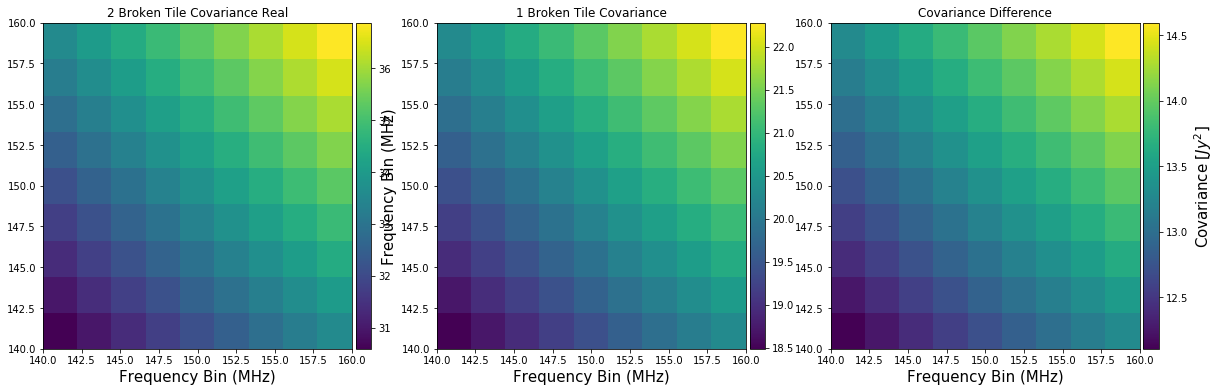

In [31]:
numerical_covariance1 = numpy.cov(visibility_realisations1)
numerical_covariance2 = numpy.cov(visibility_realisations2)

dV = visibility_realisations1 - numpy.tile(model_1.T,(16,1)).T
perturbation_covariance_npcov = numpy.cov(dV)

dV_tiled = numpy.tile(dV,(10,1,1))
dV_tiledT= numpy.transpose(dV_tiled, axes = (1,0,2))

print(dV_tiledT.shape)
perturbation_covariance_manual= numpy.mean(dV_tiled*numpy.conj(dV_tiledT), axis = 2) - \
    numpy.mean(dV_tiled, axis = 2 )*numpy.mean(numpy.conj(dV_tiledT), axis = 2 ) 

fontsize = 15
if calculate_covariance:
    %matplotlib inline
    figure = pyplot.figure(figsize = (20,6))
    
    covariance_plot_2tile = figure.add_subplot(131)
    covariance_plot_1tile = figure.add_subplot(132)
    covariance_plotdiff = figure.add_subplot(133)

    numerical_plot_1tile = covariance_plot_1tile.pcolor(frequency_range/1e6, frequency_range/1e6,
                                              numpy.abs(numerical_covariance1))
    covariance_plot_1tile.set_xlabel('Frequency Bin (MHz)', fontsize = fontsize)
    covariance_plot_1tile.set_ylabel('Frequency Bin (MHz)', fontsize = fontsize)
    covariance_plot_1tile.set_title("1 Broken Tile Covariance" )
    n_cax = colorbar(numerical_plot_1tile)

    numerical_plot_2tile = covariance_plot_2tile.pcolor(frequency_range/1e6, frequency_range/1e6,
                                              numpy.abs(numerical_covariance2))
    covariance_plot_2tile.set_xlabel('Frequency Bin (MHz)', fontsize = fontsize)
    covariance_plot_2tile.set_title("2 Broken Tile Covariance Real" )
    n2_cax = colorbar(numerical_plot_2tile)

    
    numerical_plotdiff = covariance_plotdiff.pcolor(frequency_range/1e6, frequency_range/1e6,
                                                    numpy.abs(numerical_covariance1 - numerical_covariance2))
    covariance_plotdiff.set_xlabel('Frequency Bin (MHz)', fontsize = fontsize)
    covariance_plotdiff.set_title("Covariance Difference" )
    ndiff_cax = colorbar(numerical_plotdiff)
    ndiff_cax.set_label(r"Covariance $[Jy^2]$", fontsize = fontsize)
    
    pyplot.show()

### Check whether COV[V,V] ~ E[dVdV'] - E[dV]E[dV]

In [9]:
numerical_covariance1 = numpy.cov(visibility_realisations1)

dV = visibility_realisations1 - numpy.tile(model_1.T,(16,1)).T
perturbation_covariance_npcov = numpy.cov(dV)

dV_tiled = numpy.tile(dV,(10,1,1))

dV_tiledT= numpy.transpose(dV_tiled, axes = (1,0,2))
perturbation_covariance_manual = numpy.mean(dV_tiled*numpy.conj(dV_tiledT), axis = 2) \
        - numpy.mean(dV_tiled, axis = 2 )*numpy.mean(numpy.conj(dV_tiledT), axis = 2 ) 

 

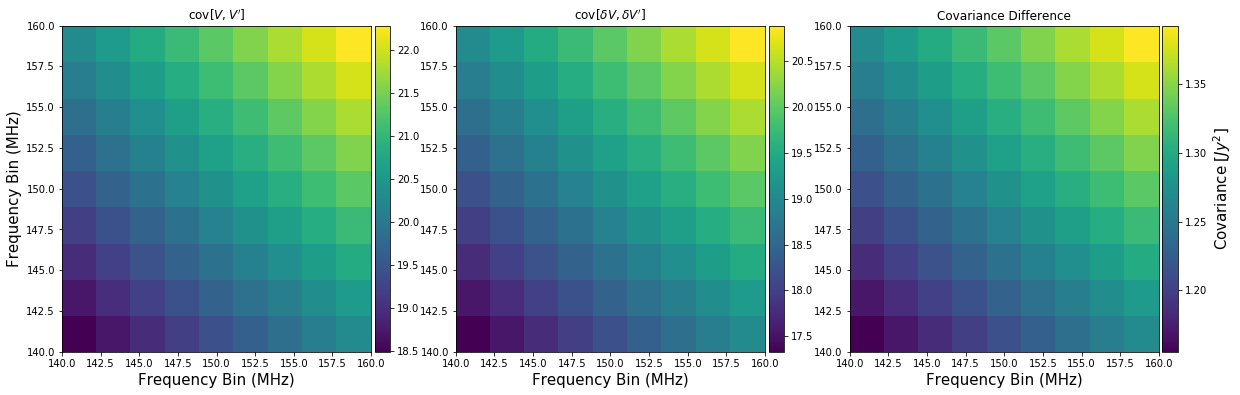

In [14]:
numerical = numpy.abs(numerical_covariance1)
approximation = numpy.abs(perturbation_covariance_manual.T)
difference = numpy.abs(numerical_covariance1 - perturbation_covariance_manual.T)


fontsize = 15
%matplotlib inline
figure = pyplot.figure(figsize = (20,6))
    
numerical_axes = figure.add_subplot(131)
approximate_axes = figure.add_subplot(132)
difference_axes = figure.add_subplot(133)

numerical_plot = numerical_axes.pcolor(frequency_range/1e6, frequency_range/1e6, numerical)
numerical_axes.set_xlabel('Frequency Bin (MHz)', fontsize = fontsize)
numerical_axes.set_ylabel('Frequency Bin (MHz)', fontsize = fontsize)
numerical_axes.set_title(r"$\mathrm{cov}[V,V']$" )
n_cax = colorbar(numerical_plot)
    
approximate_plot = approximate_axes.pcolor(frequency_range/1e6, frequency_range/1e6, approximation)
approximate_axes.set_xlabel('Frequency Bin (MHz)', fontsize = fontsize)
approximate_axes.set_title(r"$\mathrm{cov}[\delta V, \delta V']$"  )
n2_cax = colorbar(approximate_plot)
    
difference_plot = difference_axes.pcolor(frequency_range/1e6, frequency_range/1e6, difference)
difference_axes.set_xlabel('Frequency Bin (MHz)', fontsize = fontsize)
difference_axes.set_title("Covariance Difference" )
ndiff_cax = colorbar(difference_plot)
ndiff_cax.set_label(r"Covariance $[Jy^2]$", fontsize = fontsize)
    
pyplot.show()

### Test our expression for <\delta V>

In [34]:
import numpy
import sys
sys.path.append('../../../redundant_calibration/code/SCAR')

from SkyModel import flux_list_to_sky_image
from SkyModel import flux_distribution

def f(s, wavelength, dx = 1.1):
    values = numpy.zeros(s.shape)
    indices_zero = numpy.where(s == 0)
    indices_nonzero = numpy.where(s != 0)
    
    values[indices_zero] = 4
    values[indices_nonzero] =  numpy.sin(4*numpy.pi*s[indices_nonzero]*dx/wavelength[indices_nonzero])/\
    numpy.sin(numpy.pi*s[indices_nonzero]*dx/wavelength[indices_nonzero])
    
    return values

def sa_averaged_vis(xyz_positions, frequency_range, sky_param, verbose = False):
    baseline_index = 0
    gain_table = antenna_gain_creator(xyz_positions, frequency_range)
    baseline_table = baseline_converter(xyz_positions, gain_table, frequency_range, verbose = verbose)
    
    
    if sky_param[0] == 'random':
        all_flux, all_l, all_m = flux_distribution(['random', sky_seed])
    elif sky_param[0] == 'point':
        all_flux, all_l, all_m = flux_distribution(['single', sky_param[1],
                                                    sky_param[2], sky_param[3]])
    point_source_list = numpy.stack((all_flux, all_l, all_m), axis=1)
    
    sky_cube, l_coordinates, m_coordinates = flux_list_to_sky_image(point_source_list, baseline_table)
    ll, mm, ff = numpy.meshgrid(l_coordinates, m_coordinates, frequency_range)
    tt, pp, = lm_to_theta_phi(ll, mm)
    
    wavelength = c/ff

    baseline_selection = numpy.array([baseline_table[baseline_index]])
    visibility_averages = numpy.zeros((frequency_range.shape[0]), dtype=complex)
    
    ideal_beam = beam_response(ll, mm, ff)
    other_beam_thing = f(ll,wavelength)*f(mm,wavelength)
    
    for frequency_index in range(len(frequency_range)):
        visibility_averages[frequency_index] = visibility_extractor(
                baseline_selection[:, :, frequency_index], sky_cube[:, :, frequency_index],
                ideal_beam[:, :, frequency_index], other_beam_thing[:, :, frequency_index])
    
    return -visibility_averages/16**2
                

In [35]:
a_averaged_perturbation = averaged_vis(xyz_positions, frequency_range, sky_param)

/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:276: RuntimeWarning: invalid value encountered in arcsin
  theta = numpy.arcsin(numpy.sqrt(ll ** 2. + mm ** 2.))
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:277: RuntimeWarning: divide by zero encountered in true_divide
  phi = numpy.arctan(mm / ll)
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:277: RuntimeWarning: invalid value encountered in arctan
  phi = numpy.arctan(mm / ll)


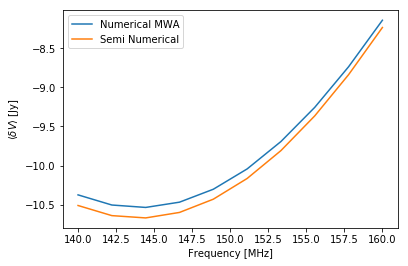

In [38]:
pyplot.plot(frequency_range/1e6, numpy.real(numpy.mean(dV, axis = 1)), label = "Numerical MWA")
pyplot.plot(frequency_range/1e6, numpy.real(a_averaged_perturbation), label = "Semi Numerical")
pyplot.xlabel("Frequency [MHz]")
pyplot.ylabel(r"$\langle \delta V \rangle$ [Jy]")
pyplot.legend()

## Check our expression for the averaged beam product <delta b delta b*>

In [4]:
import numpy
from scipy.constants import c
from matplotlib import pyplot
from quick_simulation_visibility_covariance import lm_to_theta_phi
from quick_simulation_visibility_covariance import mwa_tile_beam

def a_averaged_beam_product(l1,l2, m1, m2, f1, f2):
    wavelength1 = c/f1
    wavelength2 = c/f2
    
    ideal_beam1 = beam_response(l1, m1, wavelength1)
    ideal_beam2 = beam_response(l2, m2, wavelength2)
    
    averaged_product = ideal_beam1*ideal_beam2/16**3.*g(l1,l2,wavelength1, wavelength2)*\
        g(m1, m2, wavelength1, wavelength2)
    
    return averaged_product
    
def g(s1,s2, wavelength1, wavelength2, dx=1.1):
    values = numpy.sin(4*pi*dx*(s1/wavelength1 - s2/wavelength2))/\
    numpy.sin(pi*dx*(s1/wavelength1 - s2/wavelength2))
    
    if type(values) == numpy.ndarray:
        values[numpy.isnan(values)] = 4
    else:
        if numpy.isnan(values):
            values = 4
            
    return values
 
def n_averaged_MWA_beam_product(l1,l2, m1, m2, f1, f2):
    
    beam1 = numpy.zeros(l1.shape + (16,), dtype = complex)
    beam2 = numpy.zeros(l1.shape + (16,), dtype = complex)
    
    t1, p1, = lm_to_theta_phi(l1, m1)
    t2, p2, = lm_to_theta_phi(l2, m2)
    
    #print(m1.shape)
    
    ideal_beam1 = mwa_tile_beam(t1, p1, frequency=f1)
    ideal_beam2 = mwa_tile_beam(t2, p2, frequency=f2)

    
    for faulty_dipole in range(16):
        dipole_weights = numpy.zeros(16) + 1
        dipole_weights[faulty_dipole] = 0
        beam1[:,:, faulty_dipole] = mwa_tile_beam(t1, p1, weights=dipole_weights, frequency=f1) - ideal_beam1
        beam2[:,:, faulty_dipole] = mwa_tile_beam(t2, p2, weights=dipole_weights, frequency=f2) - ideal_beam2
        
    beam_products = beam1*numpy.conj(beam2)    
    averaged_product = numpy.mean(beam_products, axis = 2)
    
    return averaged_product

def n_averaged_gauss_beam_product(l1,l2, m1, m2, f1, f2, dx=1.1):
    x_offsets = numpy.array([-1.5, -0.5, 0.5, 1.5, -1.5, -0.5, 0.5, 1.5, -1.5,
                             -0.5, 0.5, 1.5, -1.5, -0.5, 0.5, 1.5], dtype=numpy.float32)*dx

    y_offsets = numpy.array([1.5, 1.5, 1.5, 1.5, 0.5, 0.5, 0.5, 0.5, -0.5, -0.5,
                             -0.5, -0.5, -1.5, -1.5, -1.5, -1.5], dtype=numpy.float32)*dx
    
    z_offsets = numpy.zeros(x_offsets.shape)
    
    wavelength1 = c/f1
    wavelength2 = c/f2
    
    beam1 = numpy.zeros(l1.shape + (16,), dtype = complex)
    beam2 = numpy.zeros(l1.shape + (16,), dtype = complex)

    ideal_beam1 = beam_response(l1, m1, wavelength1)
    ideal_beam2 = beam_response(l2, m2, wavelength2)
    

    
    for faulty_dipole in range(16):
        dipole_weights = numpy.zeros(16) + 1
        dipole_weights[faulty_dipole] = 0
        beam1[:,:, faulty_dipole] = -1/16*ideal_beam1*numpy.exp(-2.*numpy.pi*1j*(x_offsets[faulty_dipole]*l1 + 
                                                     y_offsets[faulty_dipole]*m1)/wavelength1)
        beam2[:,:, faulty_dipole] = -1/16*ideal_beam2*numpy.exp(-2.*numpy.pi*1j*(x_offsets[faulty_dipole]*l2 + 
                                                     y_offsets[faulty_dipole]*m2)/wavelength2)
        
    beam_products = beam1*numpy.conj(beam2)
    averaged_product = numpy.mean(beam_products, axis = 2)
    
    return averaged_product        

def averaged_plotter(l, numerical, approximation, difference):
    fontsize = 15
    %matplotlib inline
    figure = pyplot.figure(figsize = (20,6))
    
    numerical_axes = figure.add_subplot(131)
    approximate_axes = figure.add_subplot(132)
    difference_axes = figure.add_subplot(133)

    numerical_plot = numerical_axes.pcolor(l, l,numerical)
    numerical_axes.set_xlabel('l', fontsize = fontsize)
    numerical_axes.set_ylabel('l', fontsize = fontsize)
    numerical_axes.set_title(r" Numerical $\langle \delta b \delta b^{*} ']$" )
    n_cax = colorbar(numerical_plot)
    
    approximate_plot = approximate_axes.pcolor(l, l, approximation)
    approximate_axes.set_xlabel('l', fontsize = fontsize)
    approximate_axes.set_title(r" Analytic $\langle \delta b \delta b^{*} ']$"  )
    n2_cax = colorbar(approximate_plot)
    
    difference_plot = difference_axes.pcolor(l, l, difference)
    difference_axes.set_xlabel('l', fontsize = fontsize)
    difference_axes.set_title(" Difference" )
    ndiff_cax = colorbar(difference_plot)
    ndiff_cax.set_label(r"Things", fontsize = fontsize)
    
    pyplot.show()


/Users/ronniyjoseph/anaconda2/envs/python3/lib/python3.6/site-packages/powerbox/dft.py:51: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


In [5]:
l = numpy.linspace(-1,1,100)
m1 = 0
m2 = 0
f1 = 150e6
f2 = 160e6

ll1, ll2 = numpy.meshgrid(l,l)

n_mwa_averaged = n_averaged_MWA_beam_product(ll1,ll2, m1, m2, f1, f2)
n_gauss_averaged = n_averaged_gauss_beam_product(ll1,ll2, m1, m2, f1, f2)
a_averaged = a_averaged_beam_product(ll1,ll2, m1, m2, f1, f2)

/Users/ronniyjoseph/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


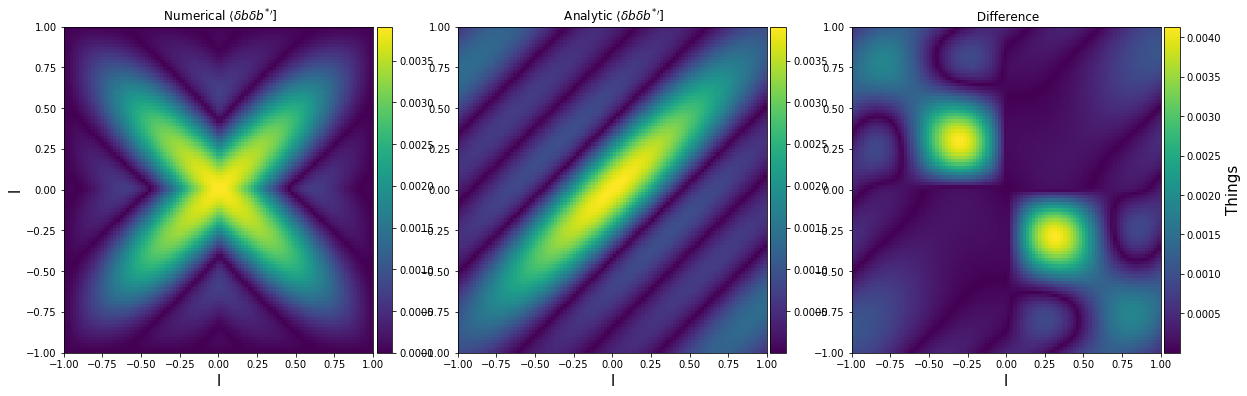

In [6]:
numerical = numpy.abs(n_mwa_averaged)
approximation = numpy.abs(n_gauss_averaged)
difference = numpy.abs(n_mwa_averaged - n_gauss_averaged)
averaged_plotter(l, numerical, approximation, difference)

/Users/ronniyjoseph/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


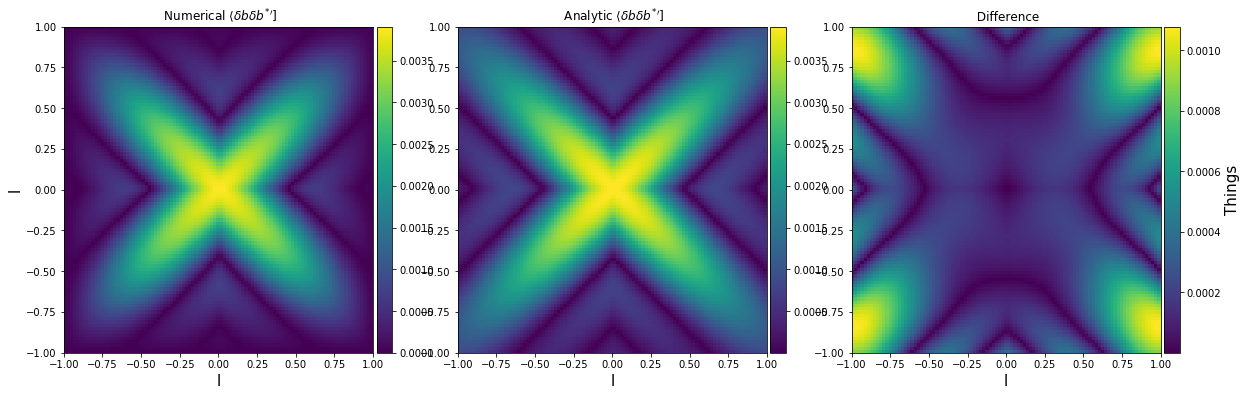

In [7]:
a2_averaged = a_averaged_beam_product(numpy.abs(ll1),numpy.abs(ll2), m1, m2, f1, f2)
n2_gauss_averaged = n_averaged_gauss_beam_product(numpy.abs(ll1),numpy.abs(ll2), m1, m2, f1, f2)

approximation = numpy.abs(n2_gauss_averaged)
difference = numpy.abs(n_mwa_averaged - n2_gauss_averaged)

averaged_plotter(l, numerical, approximation, difference)

So my expression for the averaged beam seems only to capture the diagonal component and not the anti-diagonal component. I.e only the same of of the sky is correlated with itself. Changing the coordinates to absolute coordinates seems to fix this. But what does this mean?

- Obivously there's is some symmetry causing the different part of the MWA to be correlated with each other. But I would also expect that to happen with our perturbation given that it a sinussoid.
- What does the covariance look like?

In [8]:
def n_cov_gauss_beam_product(l1, m1, f1, f2, dx=1.1):
    x_offsets = numpy.array([-1.5, -0.5, 0.5, 1.5, -1.5, -0.5, 0.5, 1.5, -1.5,
                             -0.5, 0.5, 1.5, -1.5, -0.5, 0.5, 1.5], dtype=numpy.float32)*dx

    y_offsets = numpy.array([1.5, 1.5, 1.5, 1.5, 0.5, 0.5, 0.5, 0.5, -0.5, -0.5,
                             -0.5, -0.5, -1.5, -1.5, -1.5, -1.5], dtype=numpy.float32)*dx
    
    z_offsets = numpy.zeros(x_offsets.shape)
    
    wavelength1 = c/f1
    wavelength2 = c/f2
    
    beam1 = numpy.zeros(l1.shape + (16,), dtype = complex)
    beam2 = numpy.zeros(l1.shape + (16,), dtype = complex)

    ideal_beam1 = beam_response(l1, m1, wavelength1)
    ideal_beam2 = beam_response(l1, m1, wavelength2)
    
    for faulty_dipole in range(16):
        dipole_weights = numpy.zeros(16) + 1
        dipole_weights[faulty_dipole] = 0
        beam1[...,faulty_dipole] = -1/16*ideal_beam1*numpy.exp(-2.*numpy.pi*1j*(x_offsets[faulty_dipole]*l1 + 
                                                     y_offsets[faulty_dipole]*m1)/wavelength1)
        beam2[...,faulty_dipole] = -1/16*ideal_beam2*numpy.exp(-2.*numpy.pi*1j*(x_offsets[faulty_dipole]*l1 + 
                                                     y_offsets[faulty_dipole]*m1)/wavelength2)
        
    beam_covariance = numpy.cov(beam1, beam2)    
    return beam_covariance


def n_cov_MWA_beam_product(l1, m1, f1, f2):
    beam1 = numpy.zeros(l1.shape + (16,), dtype = complex)
    beam2 = numpy.zeros(l1.shape + (16,), dtype = complex)
    
    t1, p1, = lm_to_theta_phi(l1, m1)
    t2, p2, = lm_to_theta_phi(l1, m1)
    
    ideal_beam1 = mwa_tile_beam(t1, p1, frequency=f1)
    ideal_beam2 = mwa_tile_beam(t2, p2, frequency=f2)

    
    for faulty_dipole in range(16):
        dipole_weights = numpy.zeros(16) + 1
        dipole_weights[faulty_dipole] = 0
        beam1[...,faulty_dipole] = mwa_tile_beam(t1, p1, weights=dipole_weights, frequency=f1)# - ideal_beam1
        beam2[...,faulty_dipole] = mwa_tile_beam(t2, p2, weights=dipole_weights, frequency=f2)# - ideal_beam2
        
    beam_covariance = numpy.cov(beam1, beam2)
    return beam_covariance

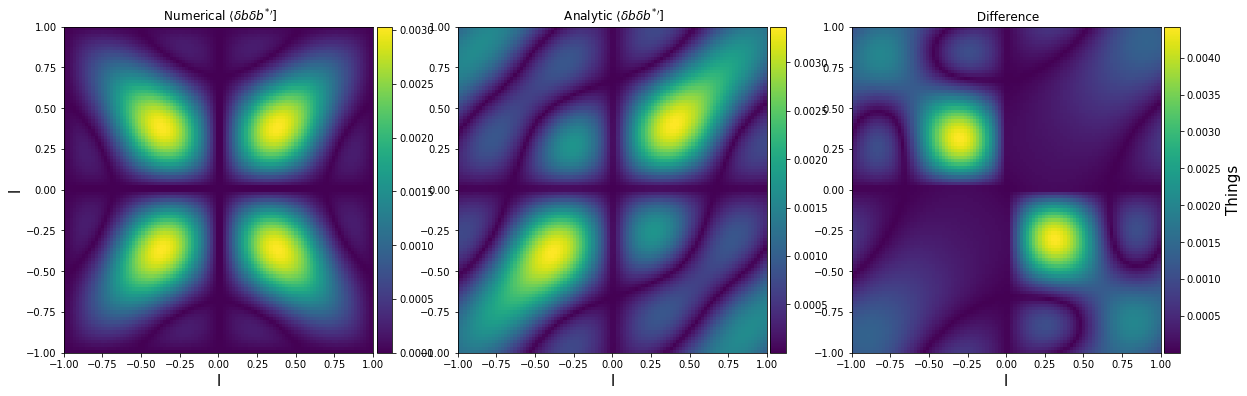

In [9]:
gauss_perturb_covariance = n_cov_gauss_beam_product(l, m1, f1, f2)[:l.shape[0],:l.shape[0]]
mwa_perturb_covariance = n_cov_MWA_beam_product(l, m1, f1, f2)[:l.shape[0],:l.shape[0]]

numerical = numpy.abs(mwa_perturb_covariance)
approximation= numpy.abs(gauss_perturb_covariance)
difference = numpy.abs(mwa_perturb_covariance - gauss_perturb_covariance)

averaged_plotter(l, numerical, approximation, difference)

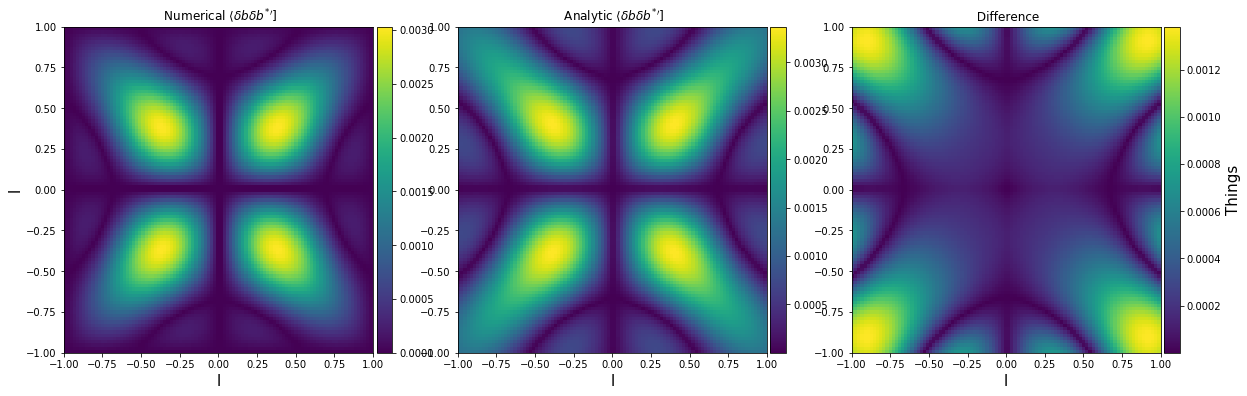

In [10]:
gauss_perturb_covariance = n_cov_gauss_beam_product(numpy.abs(l), m1, f1, f2)[:l.shape[0],:l.shape[0]]
mwa_perturb_covariance = n_cov_MWA_beam_product(l, m1, f1, f2)[:l.shape[0],:l.shape[0]]

numerical = numpy.abs(mwa_perturb_covariance)
approximation= numpy.abs(gauss_perturb_covariance)
difference = numpy.abs(mwa_perturb_covariance - gauss_perturb_covariance)

averaged_plotter(l, numerical, approximation, difference)

## Understanding our approximated beam

So basically we can get the symmetric component into our approximation by replacing l by |l| in our beam perturbation. So let's compare, calculate the 16 beams MWA-style, Gaussian style, Absolute Gaussian style.

/Users/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:279: RuntimeWarning: invalid value encountered in arcsin
  theta = numpy.arcsin(numpy.sqrt(ll ** 2. + mm ** 2.))
/Users/ronniyjoseph/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10
/Users/ronniyjoseph/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10
/Users/ronniyjoseph/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10


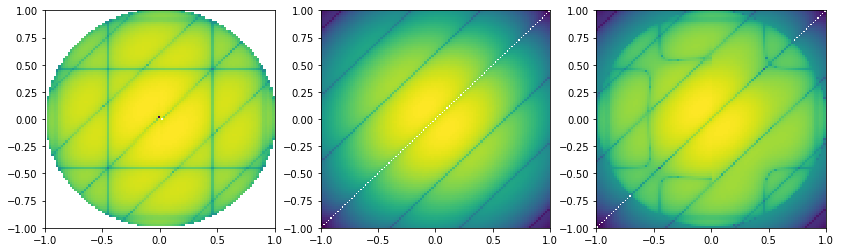

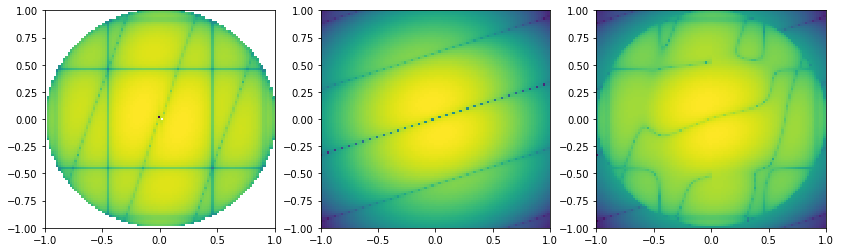

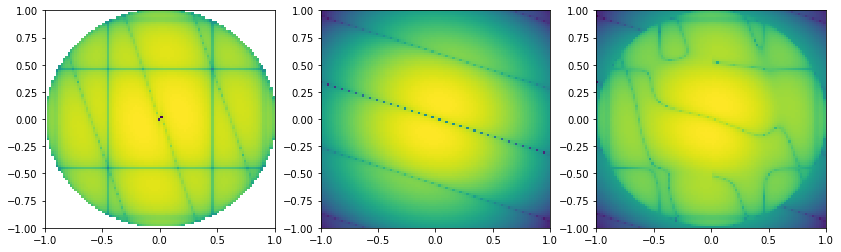

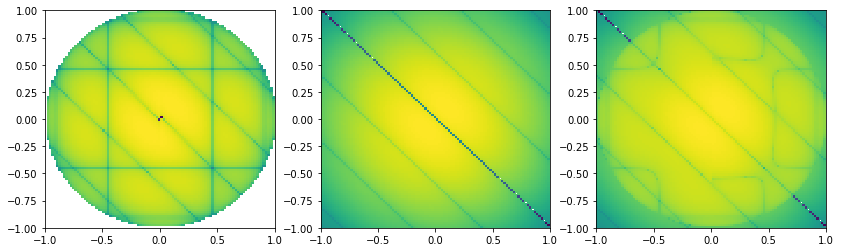

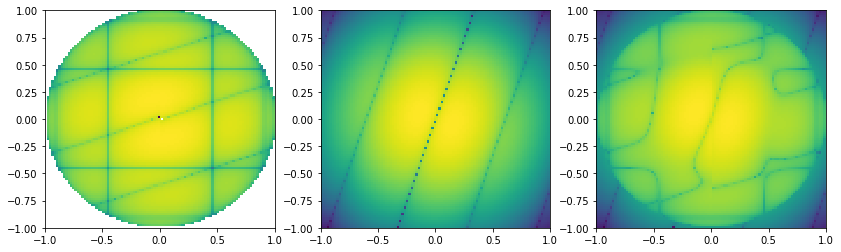

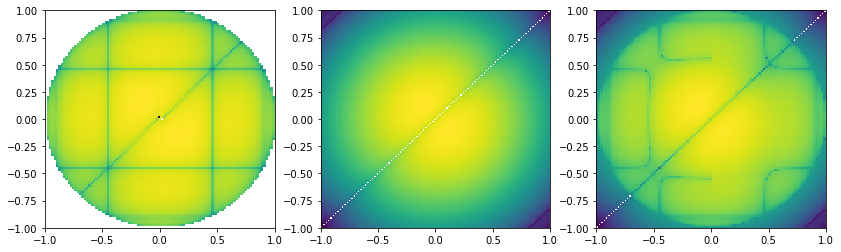

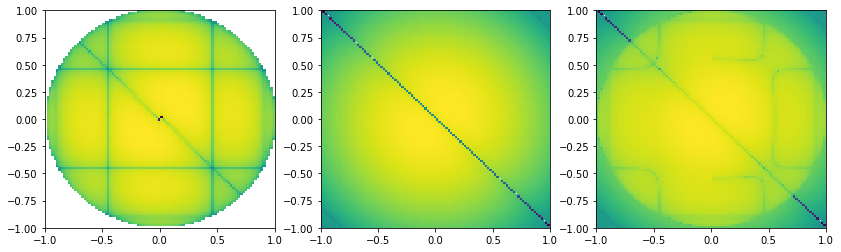

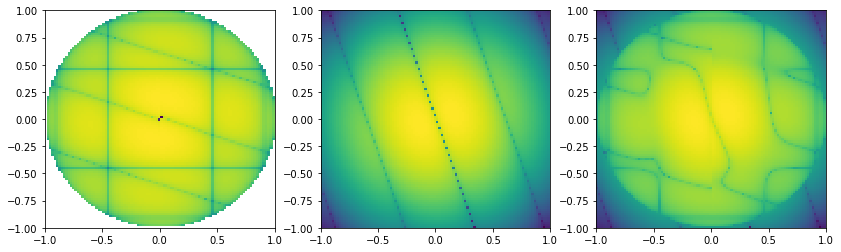

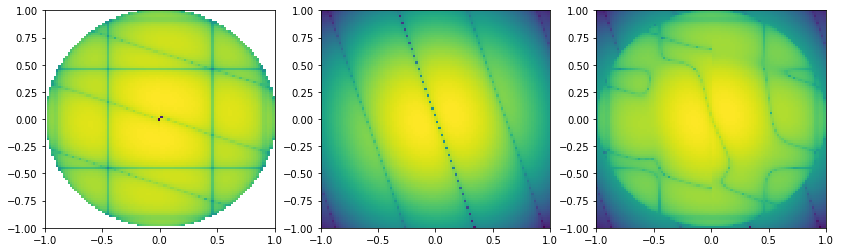

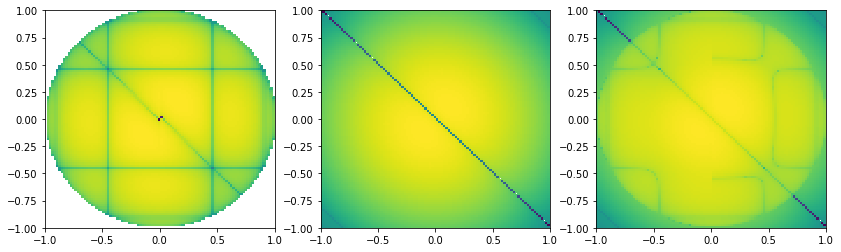

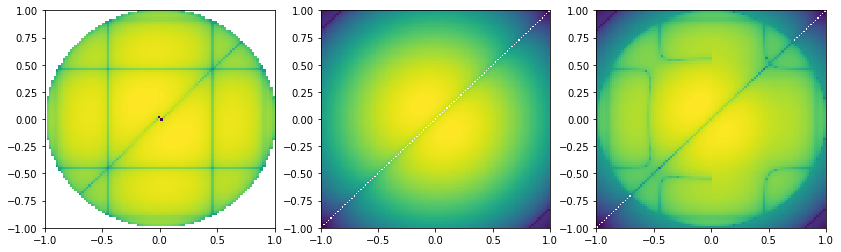

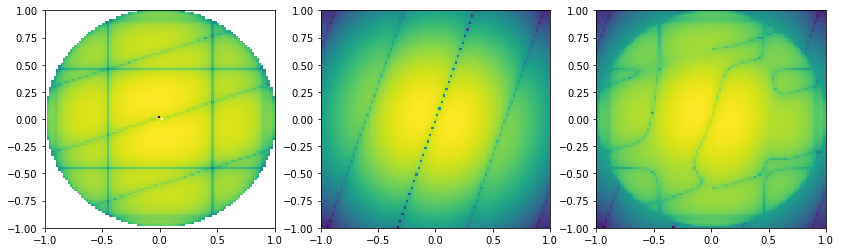

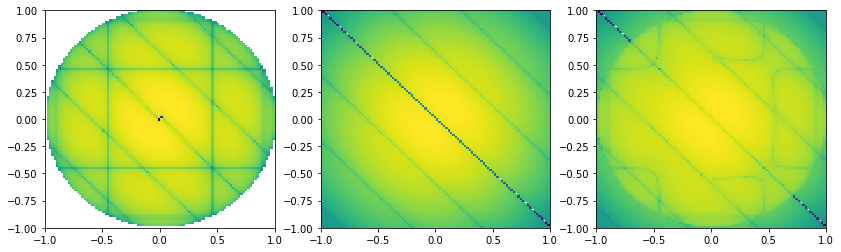

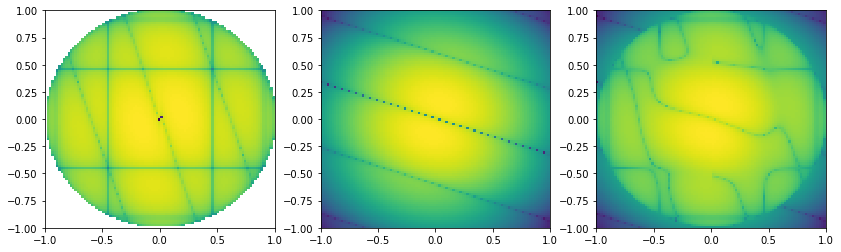

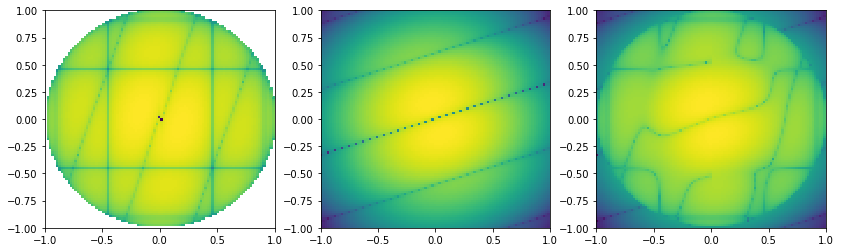

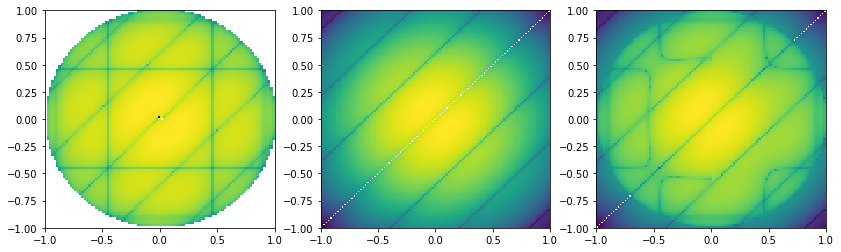

In [11]:
l = numpy.linspace(-1,1,100)
m = l.copy()
frequency = 150e6

ll, mm = numpy.meshgrid(l,m)
tt, pp = lm_to_theta_phi(ll, mm)

mwa_ideal_beam = mwa_tile_beam(theta=tt, phi=pp, frequency=frequency)
gauss_ideal_beam = beam_response(ll, mm, frequency)

dx = 1.1
x_offsets = numpy.array([-1.5, -0.5, 0.5, 1.5, -1.5, -0.5, 0.5, 1.5, -1.5,
                             -0.5, 0.5, 1.5, -1.5, -0.5, 0.5, 1.5], dtype=numpy.float32)*dx

y_offsets = numpy.array([1.5, 1.5, 1.5, 1.5, 0.5, 0.5, 0.5, 0.5, -0.5, -0.5,
                             -0.5, -0.5, -1.5, -1.5, -1.5, -1.5], dtype=numpy.float32)*dx

wavelength = c/frequency

for faulty_dipole in range(16):
    dipole_weights = numpy.zeros(16) + 1
    dipole_weights[faulty_dipole] = 0
    mwa_pert_beam = mwa_tile_beam(theta=tt, phi=pp, frequency=frequency, weights=dipole_weights)
    mwa_baseline_beam = mwa_ideal_beam*numpy.conj(mwa_pert_beam)
    
    gauss_pert_beam = gauss_ideal_beam*(1-1/16)*numpy.exp(-2.*numpy.pi*1j*(x_offsets[faulty_dipole]*ll + 
                                                     y_offsets[faulty_dipole]*mm)/wavelength)
    gauss_baseline_beam = gauss_ideal_beam*numpy.conj(gauss_pert_beam)
    
    diff_baseline_beam = mwa_baseline_beam - gauss_baseline_beam
    
    figure = pyplot.figure(figsize = (14,4))
    mwa_plot = figure.add_subplot(131)
    gauss_plot = figure.add_subplot(132)
    diff_plot = figure.add_subplot(133)
    
    mwa_plot.pcolor(l,m, numpy.log10(numpy.abs(numpy.imag(mwa_baseline_beam))))
    gauss_plot.pcolor(l,m, numpy.log10(numpy.abs(numpy.imag(gauss_baseline_beam))))
    diff_plot.pcolor(l,m, numpy.log10(numpy.abs(numpy.imag(diff_baseline_beam))))
    
    pyplot.show()
    